In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scienceplots
import pandas as pd
from tensorflow import keras
from utils.helper import (
    folder_to_sequence,
    MinMaxScaler_AE,
)

plt.style.use(["science", "ieee", "notebook"])

plt.rcParams["font.size"] = 12
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["figure.figsize"] = (9, 4)

In [3]:
# carregando os dados para a memória
DEFAULT_WS = 20
normal = folder_to_sequence("VIDRO-B3", DEFAULT_WS)

anomalies = [
    folder_to_sequence("ANOMALIAS/B3+200g", DEFAULT_WS),
    folder_to_sequence("ANOMALIAS/B3-200g", DEFAULT_WS),
    folder_to_sequence("PAINCO", DEFAULT_WS),
    folder_to_sequence("VIDRO-B2", DEFAULT_WS),
]

transient = folder_to_sequence("ANOMALIAS/Transiente", DEFAULT_WS)

100%|██████████| 1/1 [00:00<00:00, 20.64it/s]


In [4]:
scaler = MinMaxScaler_AE()
scaler.fit(normal)
autoencoder = keras.models.load_model("best_model.keras")

In [5]:
# 1) Analisar os erros no conjunto de treino

def get_error_dist(data: np.ndarray) -> np.ndarray:
    xnorm = scaler.transform(data)
    xpred = autoencoder.predict(xnorm)

    xnorm = np.squeeze(xnorm, axis=-1)
    errors = np.mean(np.abs(xnorm - xpred), axis=1)

    return errors

def plot_error_dist(error_dist: np.ndarray, threshold: float, color: str, cumulative=False,):
    fig, ax = plt.subplots()
    ax.grid()
    sns.histplot(
        error_dist,
        kde=True,
        bins=50,
        color=color,
        stat="percent",
        ax=ax,
        cumulative=cumulative,
    )
    ax.set_ylabel(r"Porcentagem (%)")
    ax.set_xlabel("Erro médio absoluto")
    ax.axvline(threshold, color="black", linestyle="--", label="Limiar")
    ax.legend()
    ax.legend(title=f"Acurácia: {get_accuracy(error_dist, threshold) * 100:.2f}%")
    return ax

In [6]:
def get_accuracy(errors: np.ndarray, threshold: float) -> float:
    anomalies = errors > threshold
    accuracy: float = np.mean(anomalies)
    return accuracy

In [7]:
normal_err = get_error_dist(normal)
threshold = np.percentile(normal_err, 95)

1032/1032 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step


<Axes: xlabel='Erro médio absoluto', ylabel='Porcentagem (%)'>

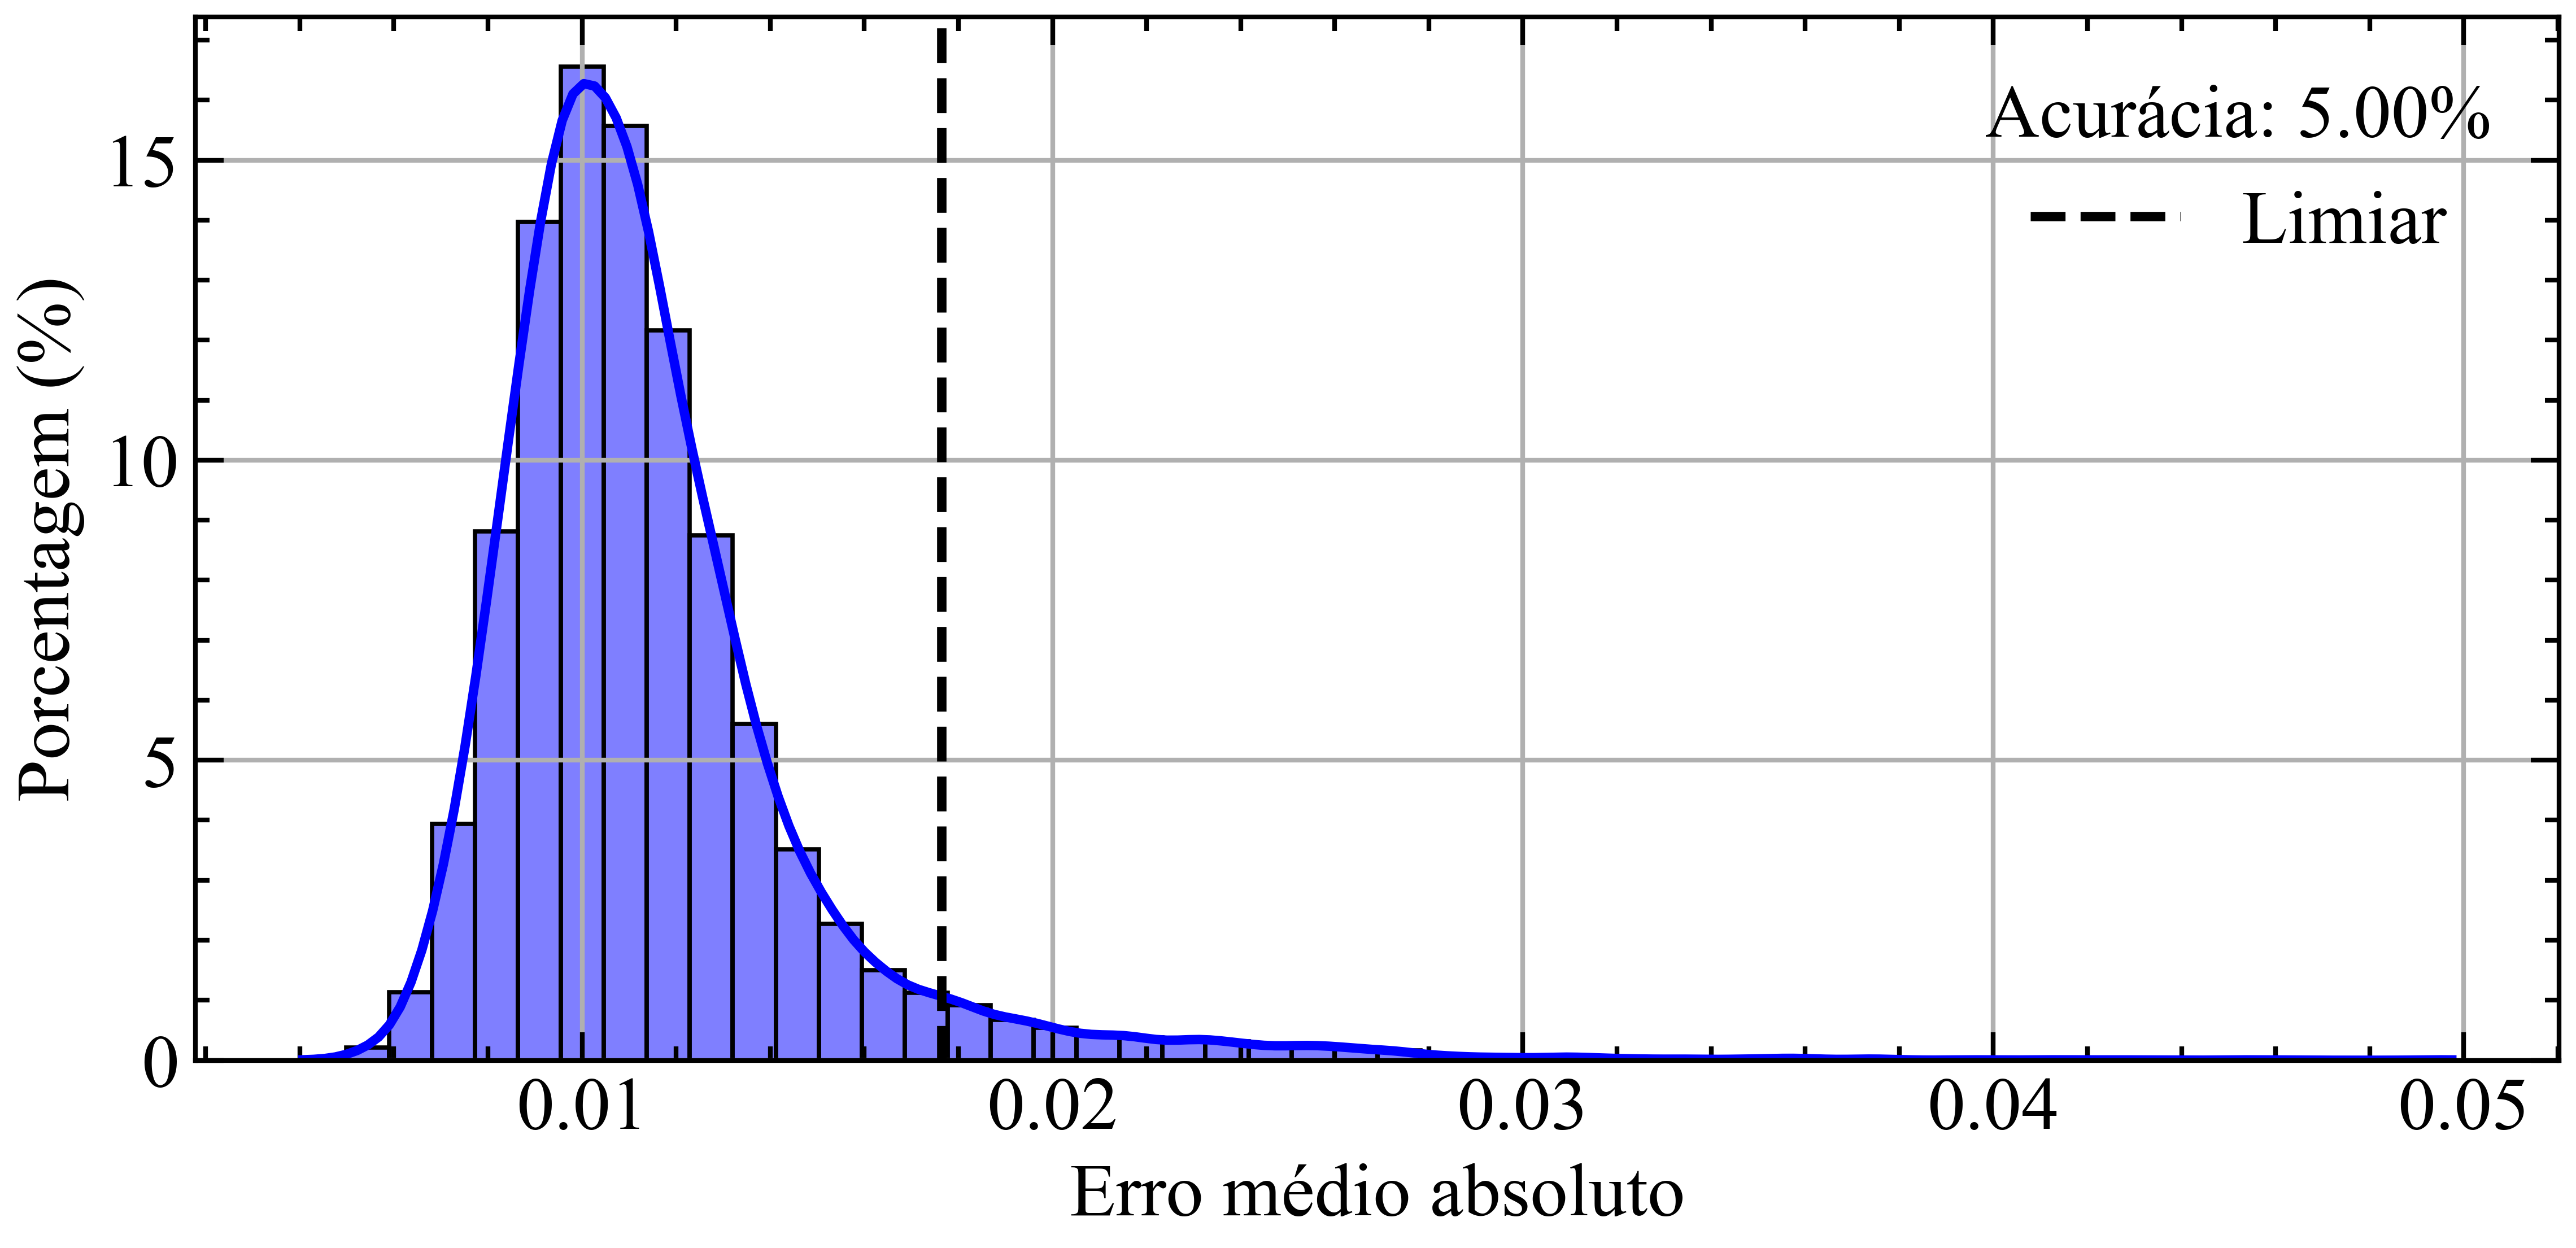

In [8]:
plot_error_dist(normal_err, threshold, "blue")

In [9]:
errors = [get_error_dist(anomaly) for anomaly in anomalies]

281/281 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
271/271 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
238/238 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


<Axes: xlabel='Erro médio absoluto', ylabel='Porcentagem (%)'>

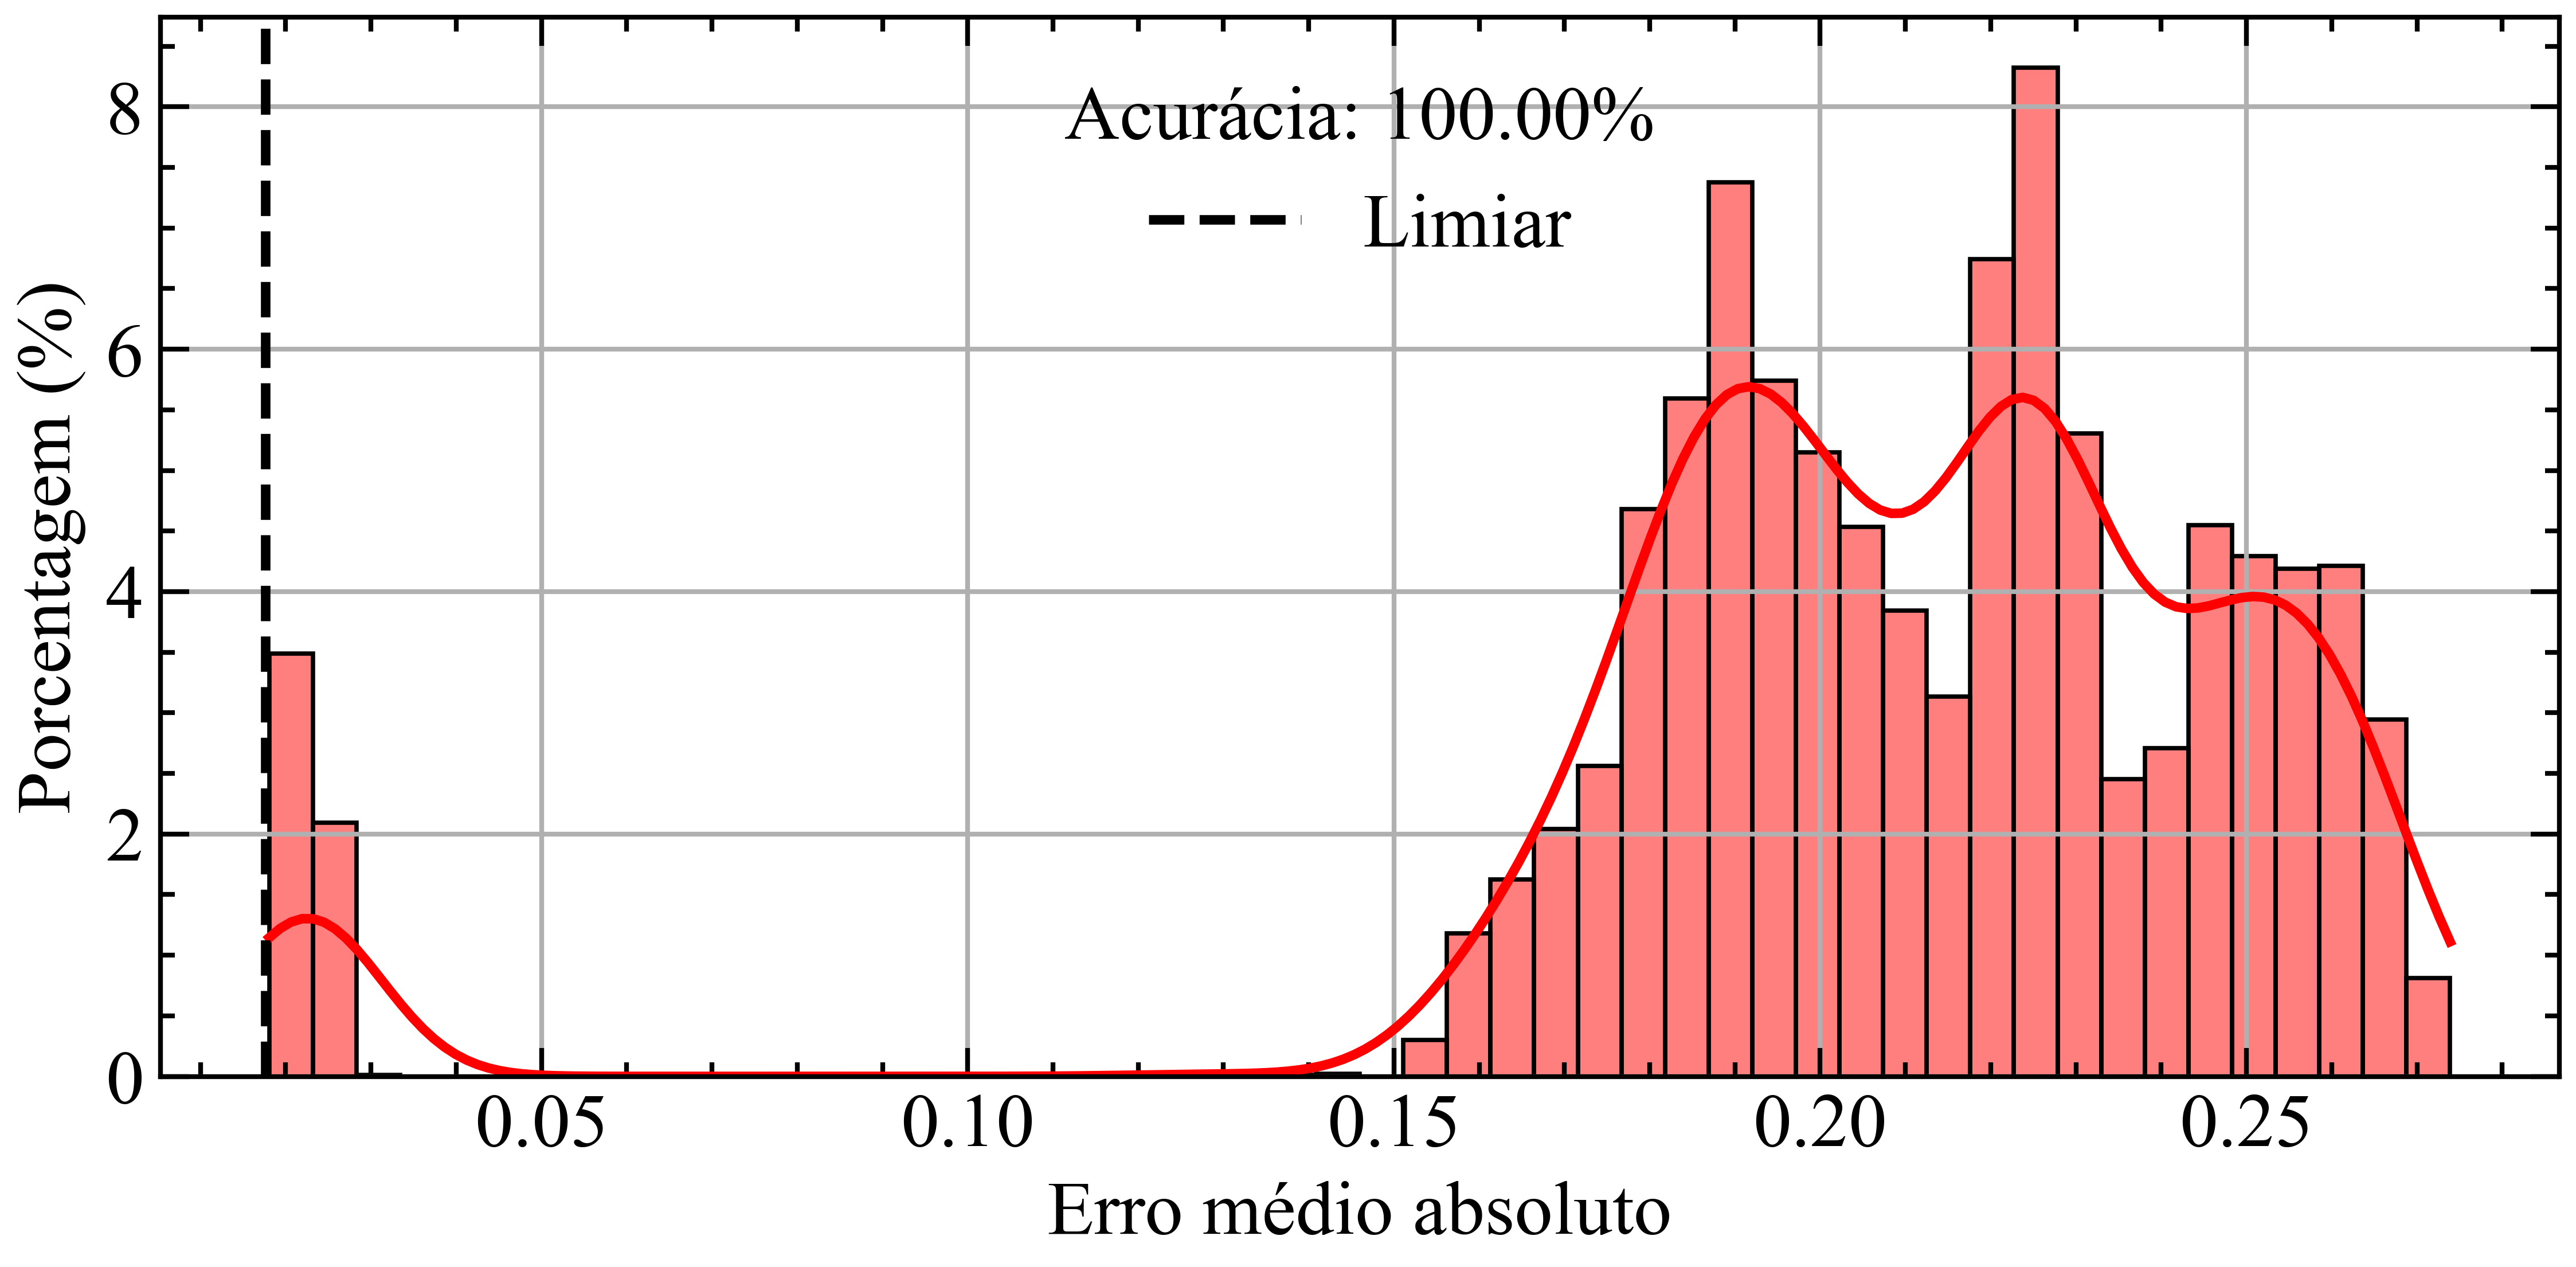

In [10]:
plot_error_dist(errors[0], threshold, "red")

<Axes: xlabel='Erro médio absoluto', ylabel='Porcentagem (%)'>

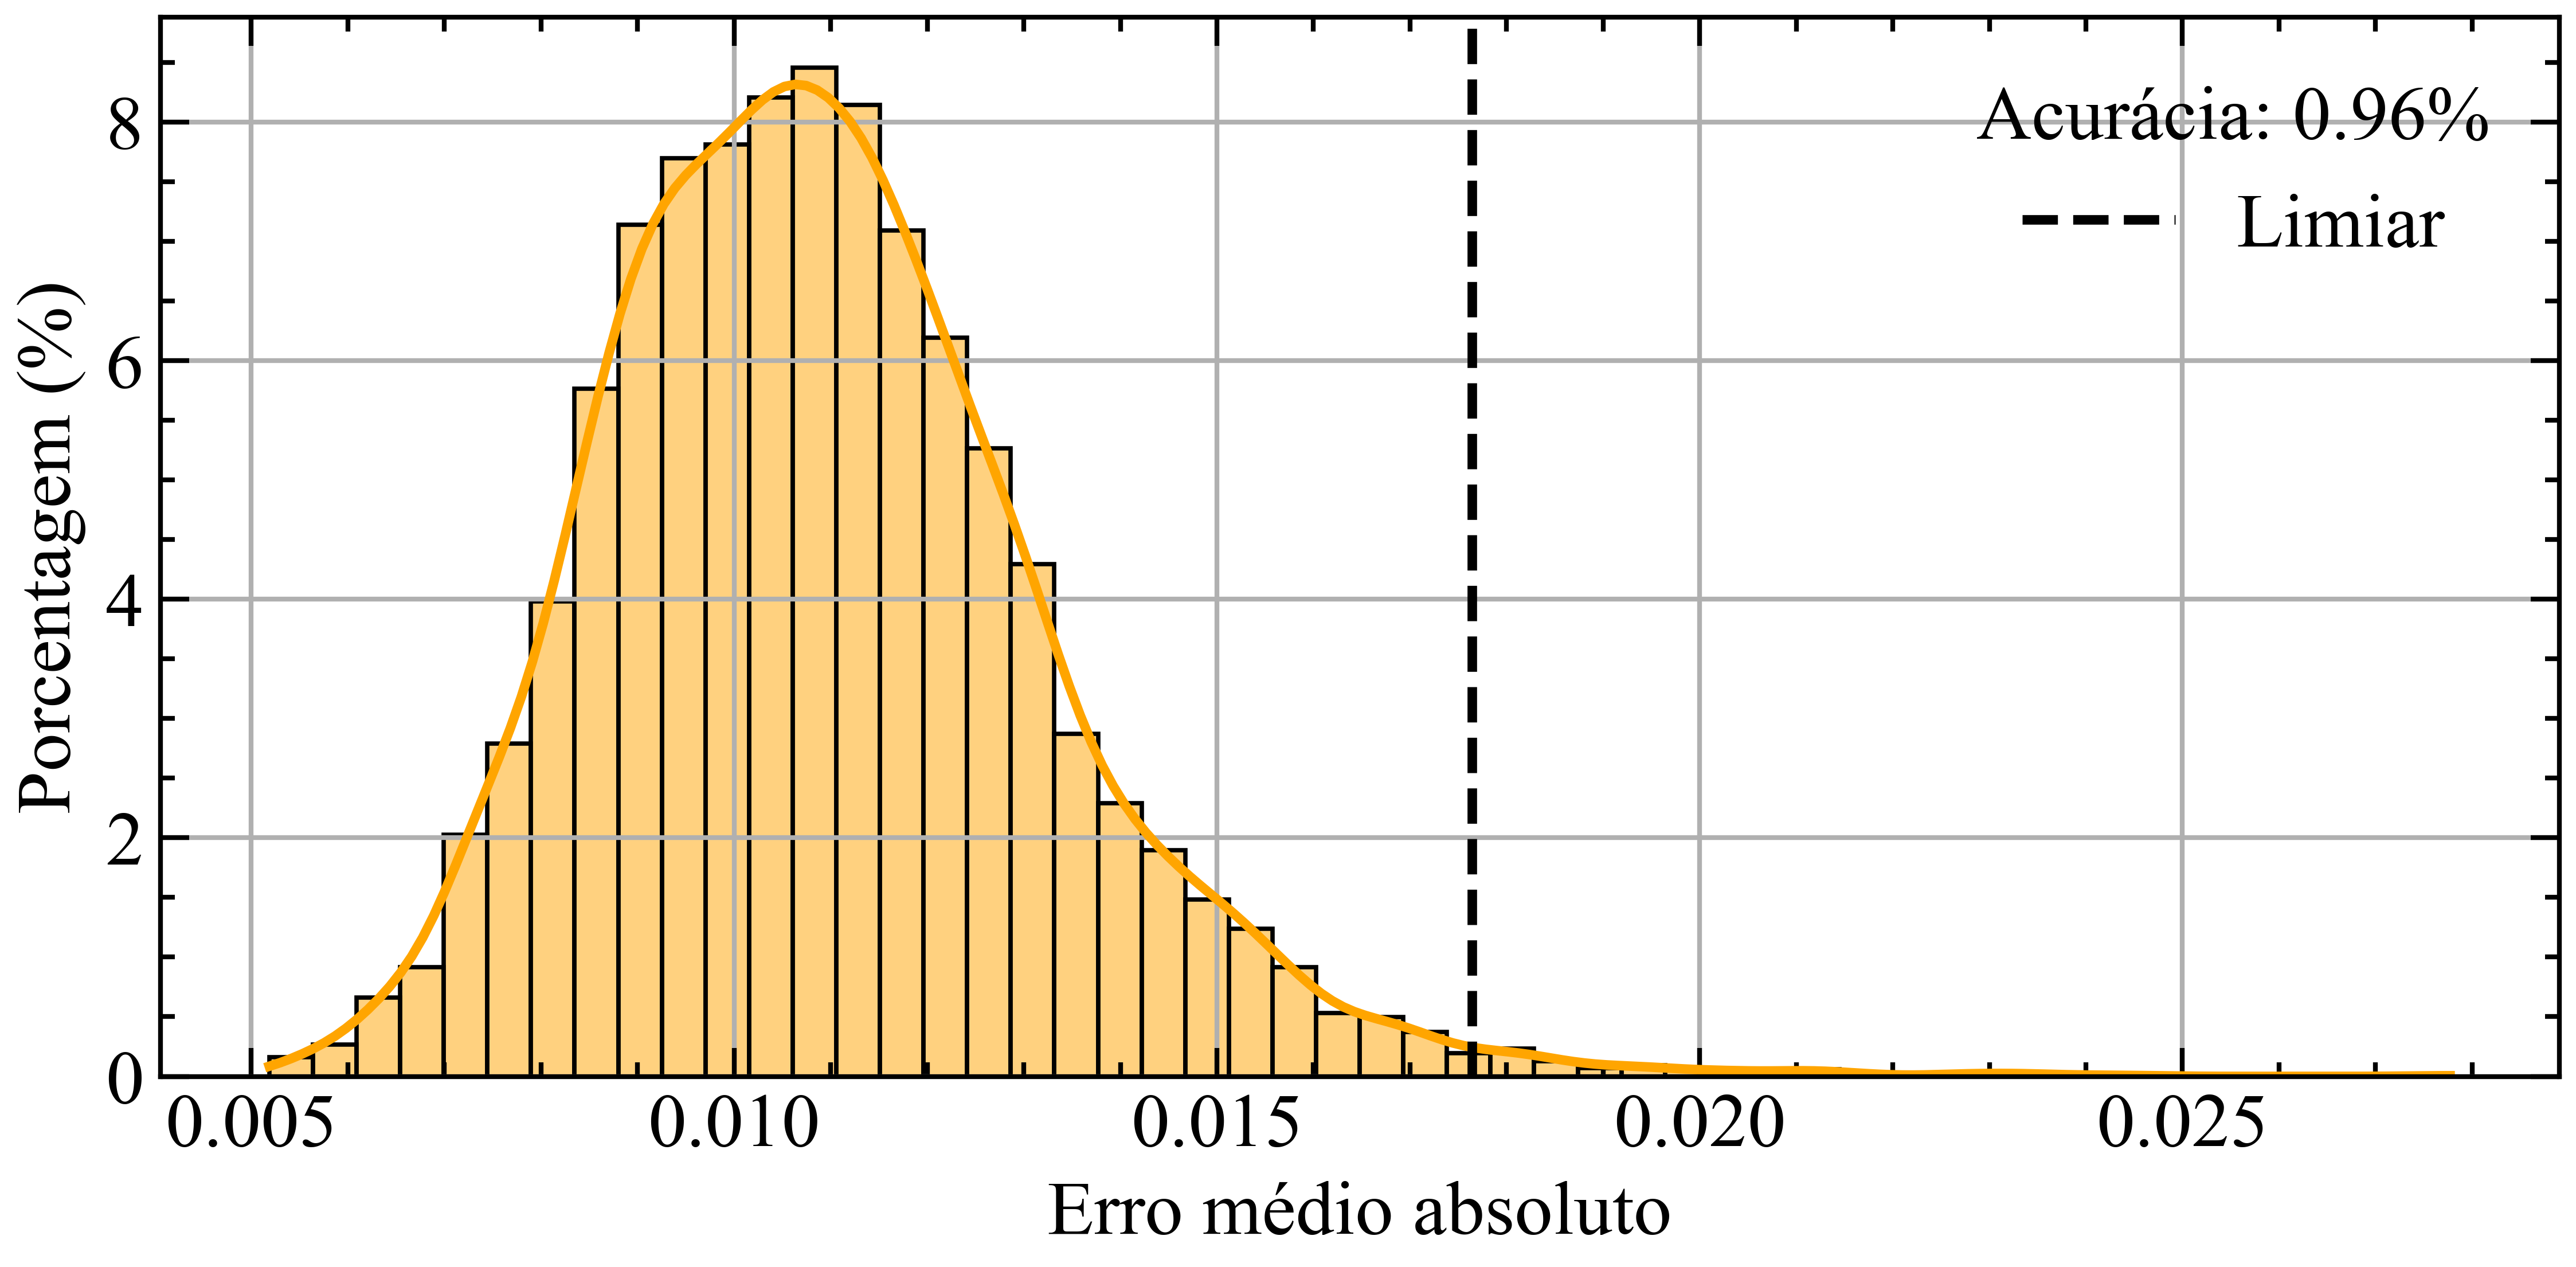

In [12]:
plot_error_dist(errors[1], threshold, "orange")

<Axes: xlabel='Erro médio absoluto', ylabel='Porcentagem (%)'>

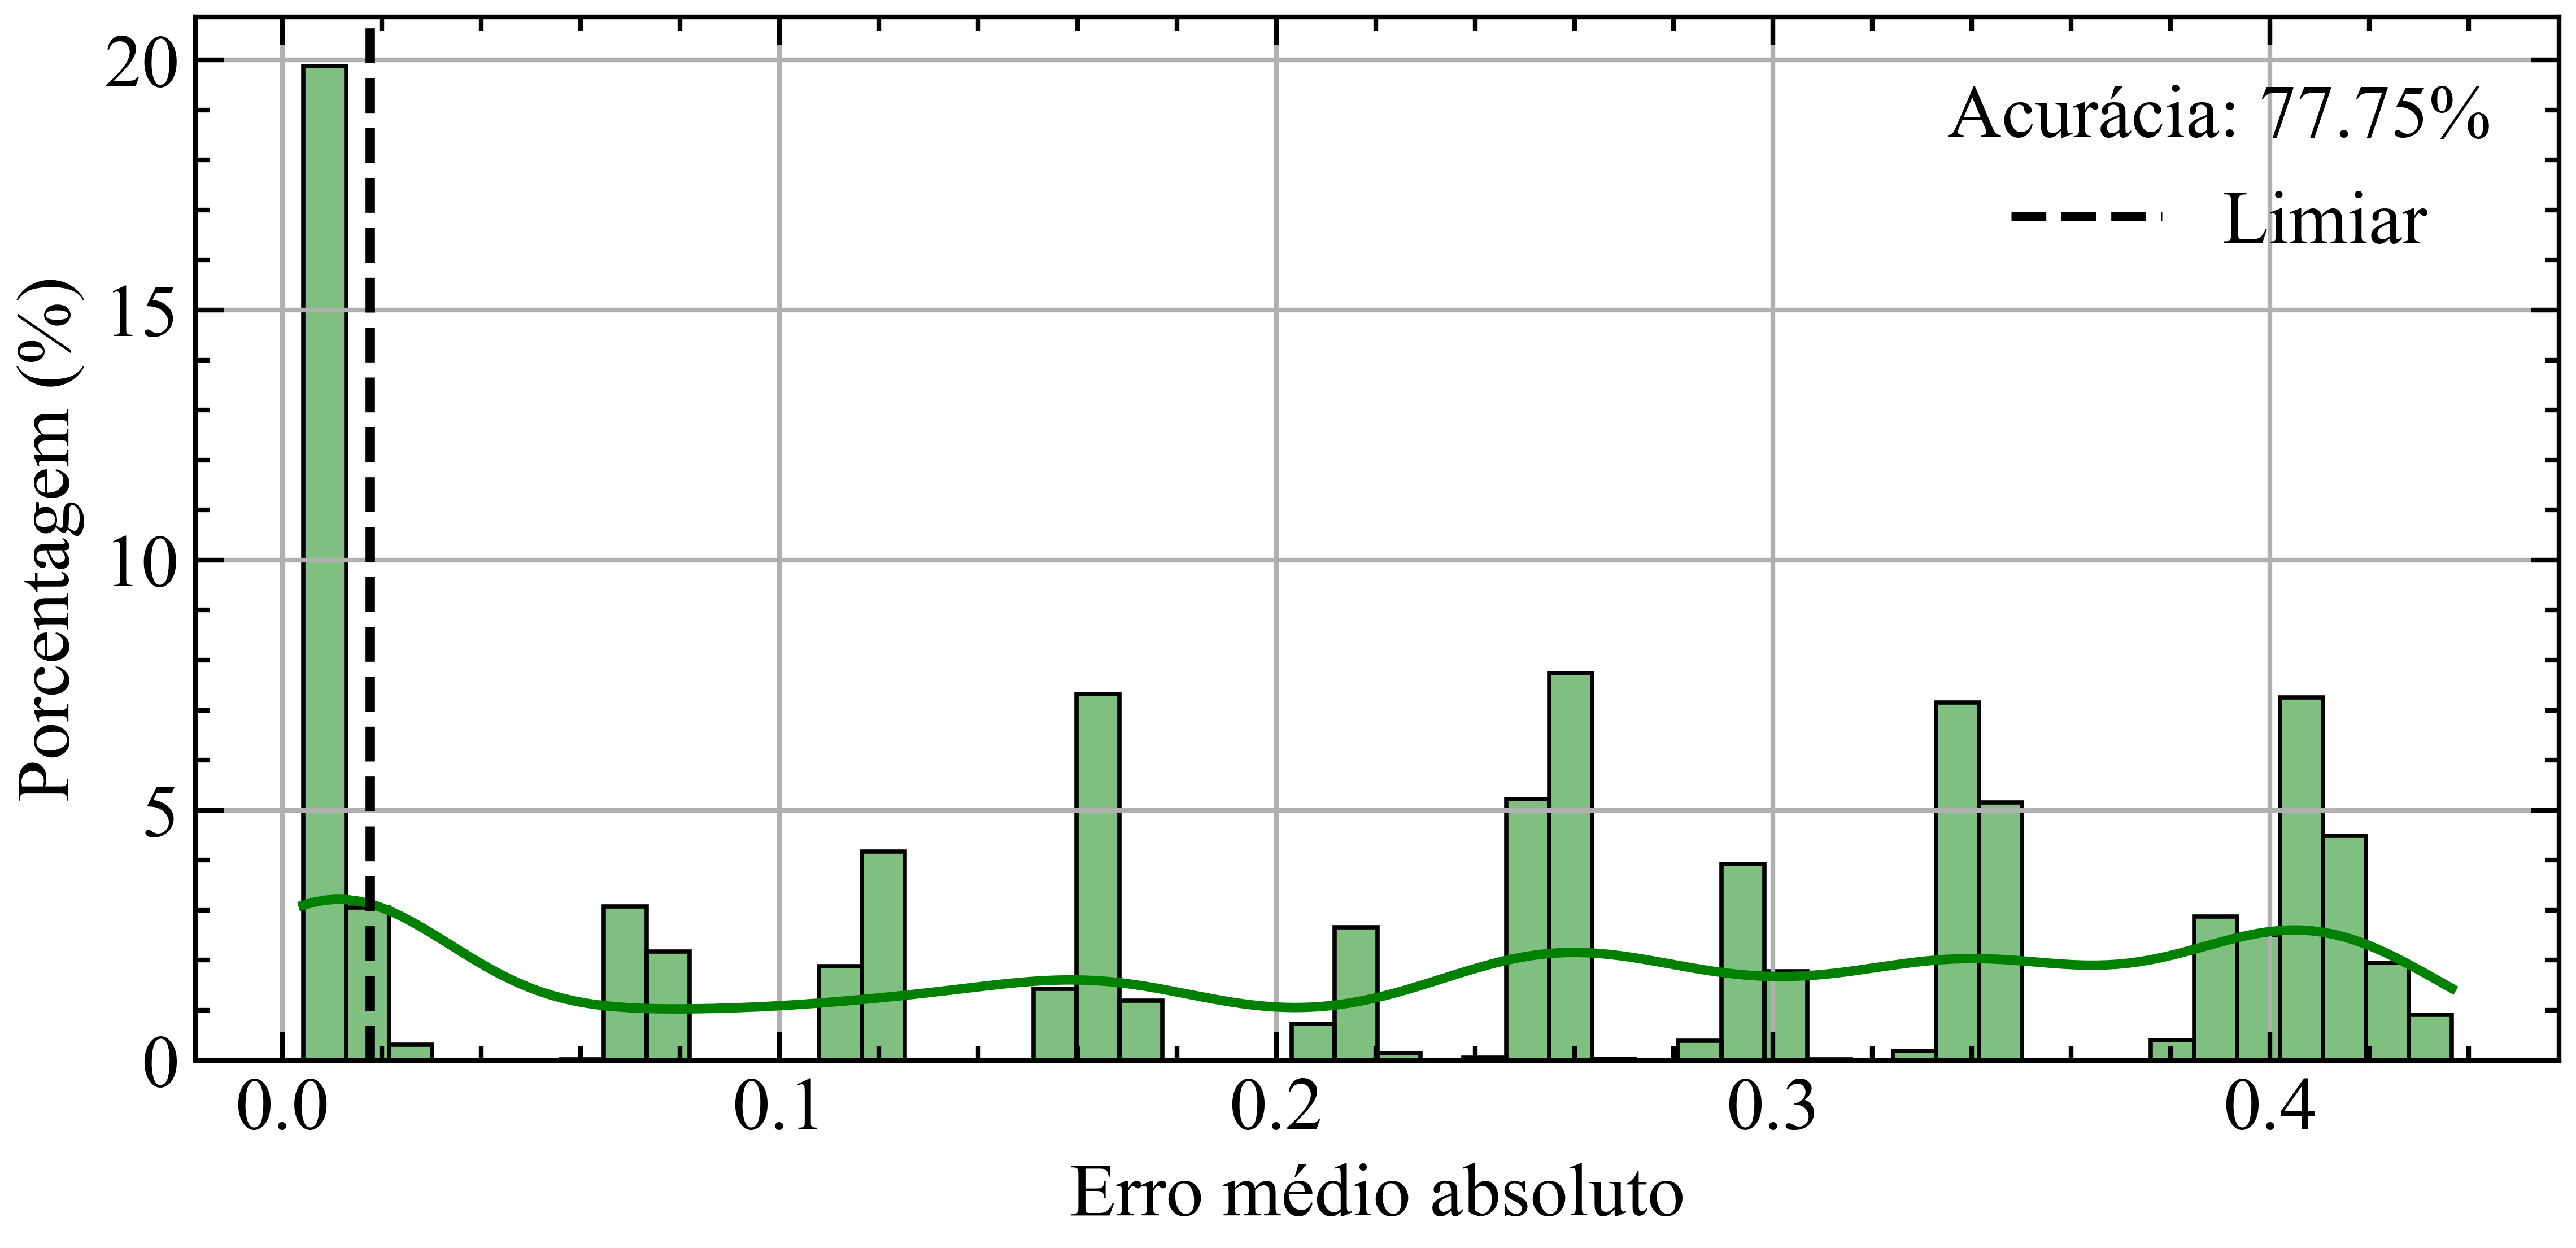

In [20]:
plot_error_dist(errors[2], threshold, "green")

36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


(<Figure size 5400x2400 with 1 Axes>,
 <Axes: title={'center': 'Anomaly Detection'}, xlabel='Time', ylabel='Value'>)

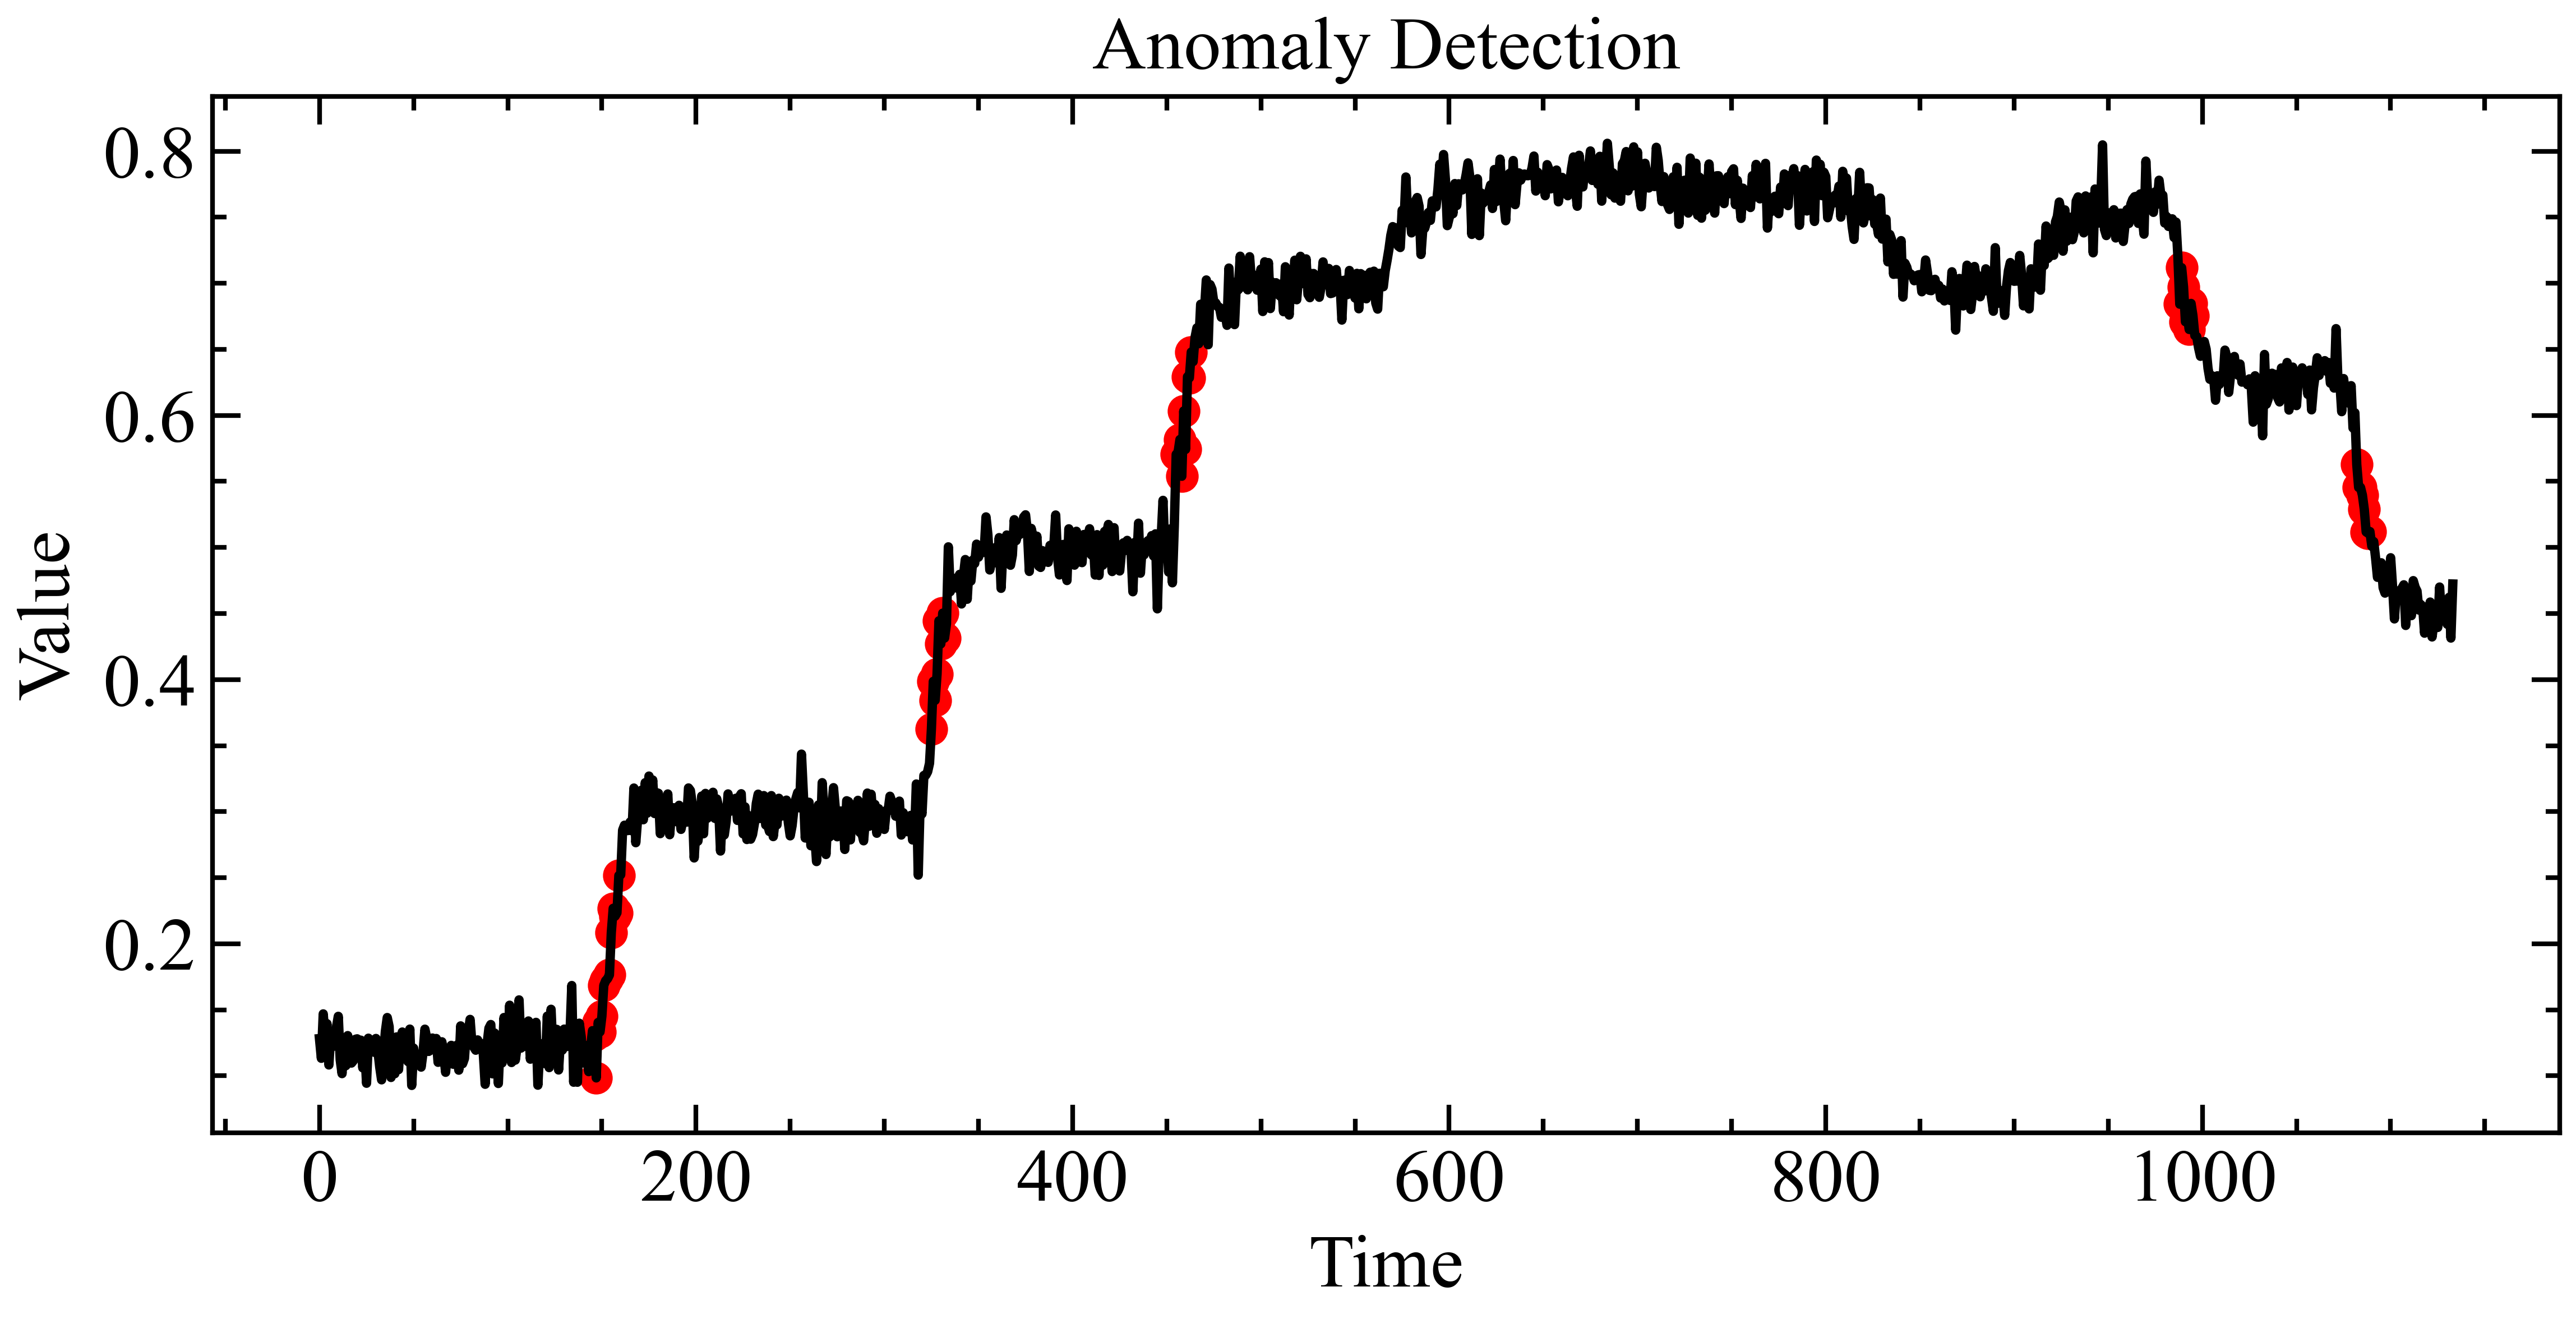

In [19]:
def plot_anomalies(data: np.ndarray, errors: np.ndarray, max_error: float, window_size: int = DEFAULT_WS):
    anomaly_points = errors > max_error
    combined_anomaly_points = np.zeros_like(anomaly_points, dtype=bool)
    for i in range(window_size - 1, len(anomaly_points)):
        if np.all(anomaly_points[i - window_size + 1 : i + 1]):
            combined_anomaly_points[i] = True

    fig, ax = plt.subplots()
    ax.plot(data[:, 0, 0])
    ax.scatter(
        np.where(combined_anomaly_points)[0], data[combined_anomaly_points, 0, 0], c="r"
    )
    ax.set_title("Anomaly Detection")
    ax.set_xlabel("Time")
    ax.set_ylabel("Value")
    return fig, ax

# Exemplo de uso da função
# index: int = 4
# plot_anomalies(anomalies[index], errors[index], threshold)
plot_anomalies(transient, get_error_dist(transient), threshold)

In [23]:
def calculate_thresholds_and_accuracies(normal_data, anomaly_data_list, percentiles=[90, 95, 100]) -> pd.DataFrame:
    # Normalize the normal data
    xnorm = scaler.transform(normal_data)
    xpred = autoencoder.predict(xnorm)
    xnorm = np.squeeze(xnorm, axis=-1)
    errors = np.mean(np.abs(xnorm - xpred), axis=1)
    
    # Calculate thresholds based on percentiles
    thresholds = {p: np.percentile(errors, p) for p in percentiles}
    
    # Calculate accuracies for each anomaly dataset
    accuracies = {p: [] for p in percentiles}
    for anomaly_data in anomaly_data_list:
        xnorm_anomaly = scaler.transform(anomaly_data)
        xpred_anomaly = autoencoder.predict(xnorm_anomaly)
        xnorm_anomaly = np.squeeze(xnorm_anomaly, axis=-1)
        errors_anomaly = np.mean(np.abs(xnorm_anomaly - xpred_anomaly), axis=1)
        
        for p in percentiles:
            threshold = thresholds[p]
            accuracy = get_accuracy(errors_anomaly, threshold)
            accuracies[p].append(accuracy)
    
    # Create a DataFrame to store the results
    results = pd.DataFrame({
        'Percentil': percentiles,
        'Limiar': [thresholds[p] for p in percentiles],
    })
    
    for i, anomaly_data in enumerate(anomaly_data_list):
        results[f'Anomaly {i+1} Acc (%)'] = [accuracies[p][i]*100 for p in percentiles]
    
    return results

# Calcular a tabela de limiares e acurácias
results_table = calculate_thresholds_and_accuracies(normal, anomalies)
results_table.set_index('Percentil', inplace=True)
print(results_table)

1032/1032 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step
281/281 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
271/271 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
238/238 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
             Limiar  Anomaly 1 Acc (%)  Anomaly 2 Acc (%)  Anomaly 3 Acc (%)  \
Percentil                                                                      
90         0.014962         100.000000           5.160842          78.939267   
95         0.017642         100.000000           0.960426          77.749790   
100        0.049746          94.404815           0.000000          76.770221   

           Anomaly 4 Acc (%)  
Percentil                     
90                  9.881423  
95                  4.861660  
100                 0.000000  
